# Project 5: Moon Phase Calendar with Events
**Authors:** Eling Cheng and Allison Trusko  
**Course:** Astron 1221  
**Semester:** Fall 2025  
**GitHub Repository Link:** https://github.com/echengpython/Moon-Phase-Calendar-2025.git

## Goal:
- Build a lunar calendar for 12 months that computes moon phase, illuminated fraction, moon rise/set times, and correlates this with user events loaded from `events.csv`.
- Identify dark-sky observing windows (illumination < 20%), supermoons, and lunar eclipses.

## Data & Tools:
- **Skyfield**: ephemeris & almanac calculations
- **Pandas / NumPy**: data wrangling
- **Matplotlib**: visualization
- **events.csv**: user events (see schema below)



## First Step:

 First, we will start by installing the necessary libraries to run this code, as shown below:

In [1]:
# Requirements cell (include in the notebook so graders can re-run)
%pip install --upgrade pip
%pip install skyfield pandas numpy matplotlib astropy



Note: you may need to restart the kernel to use updated packages.


## 🌙 Project Setup: Loading Astronomical Data with Skyfield

In this section, we initialize all the necessary tools and datasets for our Moon Phase Calendar project.
The goal is to use the Skyfield
 library to compute accurate lunar positions, illumination, and phase information throughout the year.

#### **What this code does:**

1. Imports required libraries
   
- Includes Python’s built-in modules (os, datetime, math), data handling libraries (pandas, numpy), and plotting tools (matplotlib).

2. Loads astronomical data (ephemerides)
  
- Uses Skyfield’s load() function to access the DE440s planetary ephemeris, which provides precise orbital data for the Earth, Moon, and Sun.
     - If the file doesn’t exist locally, it’s downloaded automatically and saved to a local data/ directory.
    - This ensures offline repeatability and reproducibility for future runs.

3. Defines constants and configuration
  
- Sets a 20% illumination threshold (ILLUM_THRESHOLD = 0.20) that will later be used to identify dark-sky windows which identifies optimal nights for astronomical observing.

After running this setup cell, we’ll have the fundamental objects (earth, moon, sun, and ts) ready to calculate lunar phases, illumination percentages, and observing conditions.

In [2]:
# Imports
import os
from datetime import datetime, timedelta
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Skyfield imports
from skyfield.api import load, Topos
from skyfield import almanac

# Notebook display convenience
%matplotlib inline

# Create a data dir for ephemeris if not present
DATA_DIR = 'data'
os.makedirs(DATA_DIR, exist_ok=True)

# Load timescale and ephemeris (this may download data to data/)
# If you want to avoid downloading each run, run once and commit the data/ files.
ts = load.timescale()
eph = load('de440s.bsp')  # will download if not present
earth = eph['earth']
moon = eph['moon']
sun = eph['sun']

# Constants
ILLUM_THRESHOLD = 0.20   # 20% illuminated -> dark-sky window threshold


## 🌓 Generate Lunar DataFrame with Skyfield and Pandas

This function `generate_lunar_dataframe(start_date, end_date, observer_lat=None, observer_lon=None)` builds a comprehensive **lunar calendar dataset** between two given dates.

#### **Function Overview**
- Generates a **Pandas DataFrame** containing lunar information for each day.
- Computes key astronomical parameters using **Skyfield**:
  - Lunar **phase angle** and **illumination fraction**
  - Approximate **phase name** (New, First Quarter, Full, Last Quarter)
  - **Geocentric distance** Earth–Moon (in km)
  - Optional **rise and set times** if observer coordinates are provided

#### **Key Features**
- Dates are sampled at **00:00 UTC**.
- Uses `almanac.moon_phase` to calculate the Moon’s phase angle.
- Converts phase angle to illumination fraction via  
  \[
  f = \frac{1 + \cos(\theta)}{2}
  \]
- Labels phases based on degree ranges.
- Converts **distance from AU → km** (`1 AU = 149,597,870.7 km`).
- Optionally computes **moonrise** and **moonset times** for a given observer using `almanac.risings_and_settings`.

#### **Output Columns**
| Column | Description |
|:--------|:-------------|
| `ts` | UTC timestamp string for each date |
| `phase_deg` | Lunar phase angle in degrees |
| `illum_frac` | Illuminated fraction (0–1) |
| `distance_km` | Earth–Moon distance in km |
| `phase_name` | Phase label (New, Full, etc.) |
| `dark_sky` | Boolean flag for dark-sky conditions |
| `moon_rise_utc` / `moon_set_utc` | Rise/set times in UTC (if coordinates provided) |


In [3]:
def generate_lunar_dataframe(start_date, end_date, observer_lat=None, observer_lon=None):
    """
    Generate a pandas DataFrame with lunar information for each day from start_date to end_date inclusive.
    - Dates are at midnight UTC (00:00 UTC); you can change sampling to local midnight if desired.
    - observer_lat/lon: floats for Topos to compute rise/set times. If None, rise/set columns will be NaN.
    Returns DataFrame indexed by date (datetime.date).
    """
    # build times list at 00:00 UTC for each day
    start = pd.to_datetime(start_date).normalize()
    end = pd.to_datetime(end_date).normalize()
    days = pd.date_range(start, end, freq='D')
    # create Skyfield Time object for the days at UT 00:00
    t = ts.utc(days.year.values, days.month.values, days.day.values, 0, 0, 0)

    # compute phase angle using almanac.moon_phase
    phase_angles = almanac.moon_phase(eph, t)  # returns Angle object
    # illuminated fraction formula
    illum_frac = (1 - np.cos(phase_angles.radians)) / 2.0

    # distances: compute geocentric vector from earth to moon
    # We'll observe moon from Earth's center for geocentric distance
    moon_pos = earth.at(t).observe(moon)
    distances_au = moon_pos.distance().au  # in AU
    # convert AU to km (1 AU ≈ 149597870.7 km)
    AU_TO_KM = 149597870.7
    distances_km = distances_au * AU_TO_KM

    # compute "phase name" (approx) using phase angle degrees
    phase_deg = phase_angles.degrees
    def phase_label(deg):
        deg = deg % 360
        if deg < 45 or deg >= 315:
            return 'New'
        elif 45 <= deg < 135:
            return 'First Quarter'
        elif 135 <= deg < 225:
            return 'Full'
        elif 225 <= deg < 315:
            return 'Last Quarter'
        else:
            return 'Unknown'
    phase_names = [phase_label(d) for d in phase_deg]

    # prepare DataFrame
    df = pd.DataFrame({
        'date': days.date,
        'ts': t.utc_iso(),
        'phase_deg': phase_deg,
        'illum_frac': illum_frac,
        'distance_km': distances_km,
        'phase_name': phase_names
    }).set_index('date')

    # dark-sky window flag
    df['dark_sky'] = df['illum_frac'] < ILLUM_THRESHOLD

    # If observer provided, compute risings/settings for each day
    if observer_lat is not None and observer_lon is not None:
        obs = Topos(latitude_degrees=observer_lat, longitude_degrees=observer_lon)
        # We build an almanac function that says when moon is above horizon.
        f = almanac.risings_and_settings(eph, moon, obs)
        # For each day, find the rise/set between its midnight and next midnight (UTC)
        rises = []
        sets = []
        for day in days:
            t0 = ts.utc(day.year, day.month, day.day, 0, 0, 0)
            t1_dt = day + timedelta(days=1)
            t1 = ts.utc(t1_dt.year, t1_dt.month, t1_dt.day, 0, 0, 0)
            # find_discrete returns times and events (0/1)
            times, events = almanac.find_discrete(t0, t1, f)
            # events: 0 -> setting? 1 -> rising? (check docs) We'll inspect pairs.
            # For robustness, record earliest rising and setting in that 24h window
            rise_time = None
            set_time = None
            for ti, ev in zip(times, events):
                # event is 1 for rise and 0 for set (convention used by Skyfield)
                if ev == 1 and rise_time is None:
                    rise_time = ti.utc_datetime()
                if ev == 0 and set_time is None:
                    set_time = ti.utc_datetime()
            rises.append(rise_time)
            sets.append(set_time)
        df['moon_rise_utc'] = rises
        df['moon_set_utc'] = sets

    return df

# Example: generate for 12 months starting Jan 1, 2025
start_date = '2025-01-01'
end_date = '2025-12-31'
# Columbus Latitude and Longitude for rise/set times
observer_lat = 39.9625
observer_lon = -83.0032

lunar_df = generate_lunar_dataframe(start_date, end_date, observer_lat, observer_lon)
lunar_df.head()


,ts,phase_deg,illum_frac,distance_km,phase_name,dark_sky,moon_rise_utc,moon_set_utc
date,,,,,,,,
2025-01-01,2025-01-01T00:00:00Z,13.099995,0.013012,381744.381280,New,True,2025-01-01 14:37:14.726832+00:00,NaT
2025-01-02,2025-01-02T00:00:00Z,25.622571,0.049169,378576.801881,New,True,2025-01-02 15:11:34.913525+00:00,2025-01-02 00:05:52.018785+00:00
2025-01-03,2025-01-03T00:00:00Z,38.310890,0.107671,375936.860564,New,True,2025-01-03 15:40:25.220776+00:00,2025-01-03 01:19:24.087149+00:00
2025-01-04,2025-01-04T00:00:00Z,51.122890,0.186174,373838.602934,First Quarter,True,2025-01-04 16:05:46.382954+00:00,2025-01-04 02:32:14.862798+00:00
2025-01-05,2025-01-05T00:00:00Z,64.026230,0.281020,372251.330373,First Quarter,False,2025-01-05 16:29:26.921779+00:00,2025-01-05 03:44:00.520071+00:00


### 📅 Loading and Displaying User Events

This section imports personal or user-defined events from `events.csv` and merges them with the lunar dataset:

- **Load events:** Reads the CSV file `events.csv` and parses the `date` column.
- **Merge with lunar data:** Combines event information with `lunar_df` so each day includes both lunar and event data.
- **Event flag:** Adds a Boolean column `has_event` to mark days that have events.
- **Display formatted table:** Shows the first few event days with their corresponding lunar phase, illumination, and dark-sky status.

This helps visualize how moon phases align with user activities or planned observations.


In [4]:
# Load user events
events_file = 'events.csv'  # ensure this file is next to notebook or provide instructions to obtain it
events = pd.read_csv(events_file, parse_dates=['date'])
events['date'] = events['date'].dt.date

# Merge events into lunar_df by date index
merged = lunar_df.reset_index().merge(events, left_on='date', right_on='date', how='left')
merged = merged.set_index('date')
# events may have NaN; create a boolean flag
merged['has_event'] = ~merged['title'].isna()

# Show days that have events and dark skies
events_with_data = merged[merged['has_event']][['phase_name', 'illum_frac', 'dark_sky', 'title', 'category', 'notes']]

print("🌙 Days with Events and Lunar Data:")
display(events_with_data.head(10))

🌙 Days with Events and Lunar Data:


,phase_name,illum_frac,dark_sky,title,category,notes
date,,,,,,
2025-04-22,Last Quarter,0.401326,False,Planned Observation,observation,Deep-sky imaging - target: M42
2025-05-05,First Quarter,0.543363,False,Holiday,holiday,Local festival
2025-06-15,Full,0.866804,False,Summer Solstice Party,celebration,Longest day celebration
2025-07-20,Last Quarter,0.278919,False,Apollo 11 Anniversary,celebration,56th anniversary
2025-08-12,Full,0.913236,False,Perseid Meteor Shower,observation,Best meteor shower of the year
2025-08-29,First Quarter,0.290668,False,Allie's Birthday,birthday,Allie's birthday party at 6pm
2025-09-22,New,0.000286,True,Autumn Equinox,celebration,Harvest moon celebration
2025-10-14,Last Quarter,0.473467,False,Annular Solar Eclipse,observation,Ring of fire eclipse
2025-10-31,First Quarter,0.635124,False,Halloween,holiday,Halloween party


### 🌕 Lunar Phenomena Detection and Summary Tables

This section analyzes and reports key lunar events — **supermoons**, **blue moons**, and **lunar eclipses** — using data from the `lunar_df` DataFrame and Skyfield’s ephemeris library.

#### 🌕 Supermoon Detection
- A **supermoon** occurs when a *full moon* is unusually close to Earth (within the lowest 10% of all Moon–Earth distances).
- The code filters full-moon days (`phase_name == 'Full'`), finds the 10th percentile of distances, and selects all full moons below that threshold.
- Each supermoon’s **date**, **phase name**, **illumination fraction**, and **Earth–Moon distance** (in km) are shown in a clean, formatted table.

#### 🔵 Blue Moon Detection
- A **blue moon** occurs when **two or more full moons** happen during a given month.
- The code groups all full-moon dates by year and month, checks if each month contains at least two full moons, and compiles those months.
- For each qualifying month, the **year**, **month**, and the list of **full-moon dates** are displayed in a structured table.

#### 🌑 Lunar Eclipse Detection
- Uses `skyfield.eclipselib.lunar_eclipses()` to find **penumbral**, **partial**, and **total** lunar eclipses between the start and end dates.
- Builds a table showing the **UTC time**, **numeric kind**, and **eclipse type** (0 = penumbral, 1 = partial, 2 = total).
- If no eclipses occur in the range, it reports that instead.


In [5]:
# ---------- 🌕 SUPERMOON DETECTION ----------
fulls = lunar_df[lunar_df['phase_name'] == 'Full']
threshold = np.percentile(fulls['distance_km'], 10)  # lower 10% distances → closest
supermoon_dates = fulls[fulls['distance_km'] <= threshold].index.tolist()

print("\n========== 🌕 SUPERMOONS ==========")
supermoon_table = (
    fulls[fulls['distance_km'] <= threshold][['phase_name', 'illum_frac', 'distance_km']]
    .sort_values('distance_km')
    .copy()
)

# ✅ Ensure index is a DatetimeIndex so strftime works
supermoon_table.index = pd.to_datetime(supermoon_table.index)

# ✅ Add formatted date column
supermoon_table['date'] = supermoon_table.index.strftime("%Y-%m-%d")

# format columns nicely
supermoon_table['illum_frac'] = supermoon_table['illum_frac'].map(lambda x: f"{x:.2f}")
supermoon_table['distance_km'] = supermoon_table['distance_km'].map(lambda x: f"{x:,.0f}")

# Pretty printed table
print(f"\n{'date':<12}  {'phase_name':<12}  {'illum_frac':>10}  {'distance_km':>12}")
print("-" * 54)
for _, row in supermoon_table.iterrows():
    print(f"{row['date']:<12}  {row['phase_name']:<12}  {row['illum_frac']:>10}  {row['distance_km']:>12}")


# ---------- 🔵 BLUE MOON DETECTION ----------
fulls_by_month = fulls.reset_index()
fulls_by_month['month'] = pd.to_datetime(fulls_by_month['date']).dt.month
fulls_by_month['year'] = pd.to_datetime(fulls_by_month['date']).dt.year

blue_moons = []
for (year, month), group in fulls_by_month.groupby(['year', 'month']):
    if len(group) >= 2:
        blue_moons.append({
            'year': year,
            'month': month,
            'dates': [d.strftime("%Y-%m-%d") for d in group['date']]
        })

print("\n========== 🔵 BLUE MOONS ==========")

if blue_moons:
    blue_moons_df = pd.DataFrame(blue_moons).sort_values(['year', 'month'])
    blue_moons_df['dates'] = blue_moons_df['dates'].apply(lambda lst: ", ".join(lst))

    print(f"{'year':>6}  {'month':>6}  dates")
    print("-" * 90)
    for _, row in blue_moons_df.iterrows():
        print(f"{row['year']:>6}  {row['month']:>6}  {row['dates']}")
else:
    print("No blue moons in this range.")


# ---------- 🌑 LUNAR ECLIPSES DETECTION ----------
from skyfield import eclipselib

t0 = ts.utc(pd.to_datetime(start_date).year, 1, 1)
t1 = ts.utc(pd.to_datetime(end_date).year, 12, 31, 23, 59, 59)

print("\n========== 🌑 LUNAR ECLIPSES ==========")
try:
    times, kinds, details = eclipselib.lunar_eclipses(t0, t1, eph)
    kind_labels = {0: 'Penumbral', 1: 'Partial', 2: 'Total'}
    eclipses_table = pd.DataFrame({
        'utc_time': [t.utc_datetime().strftime("%Y-%m-%d %H:%M:%S") for t in times],
        'kind': kinds
    })
    eclipses_table['type'] = eclipses_table['kind'].map(kind_labels)

    if not eclipses_table.empty:
        print(f"{'utc_time':<22}  {'kind':>6}  {'type':>10}")
        print("-" * 44)
        for _, row in eclipses_table.iterrows():
            print(f"{row['utc_time']:<22}  {row['kind']:>6}  {row['type']:>10}")
    else:
        print("No lunar eclipses in this range.")
except Exception as e:
    print("⚠️ Could not compute lunar eclipses:", e)


========== 🌕 SUPERMOONS ==========

date          phase_name    illum_frac   distance_km
------------------------------------------------------
2025-11-06    Full                1.00       356,833
2025-12-04    Full                0.99       357,185
2025-12-05    Full                1.00       357,251
2025-11-05    Full                1.00       357,714
2025-11-07    Full                0.97       357,939
2025-12-03    Full                0.94       359,057
2025-12-06    Full                0.98       359,286
2025-10-09    Full                0.95       359,996
2025-10-08    Full                0.99       360,055

========== 🔵 BLUE MOONS ==========
  year   month  dates
------------------------------------------------------------------------------------------
  2025       1  2025-01-11, 2025-01-12, 2025-01-13, 2025-01-14, 2025-01-15, 2025-01-16, 2025-01-17
  2025       2  2025-02-09, 2025-02-10, 2025-02-11, 2025-02-12, 2025-02-13, 2025-02-14, 2025-02-15, 2025-02-16
  2025       3  202

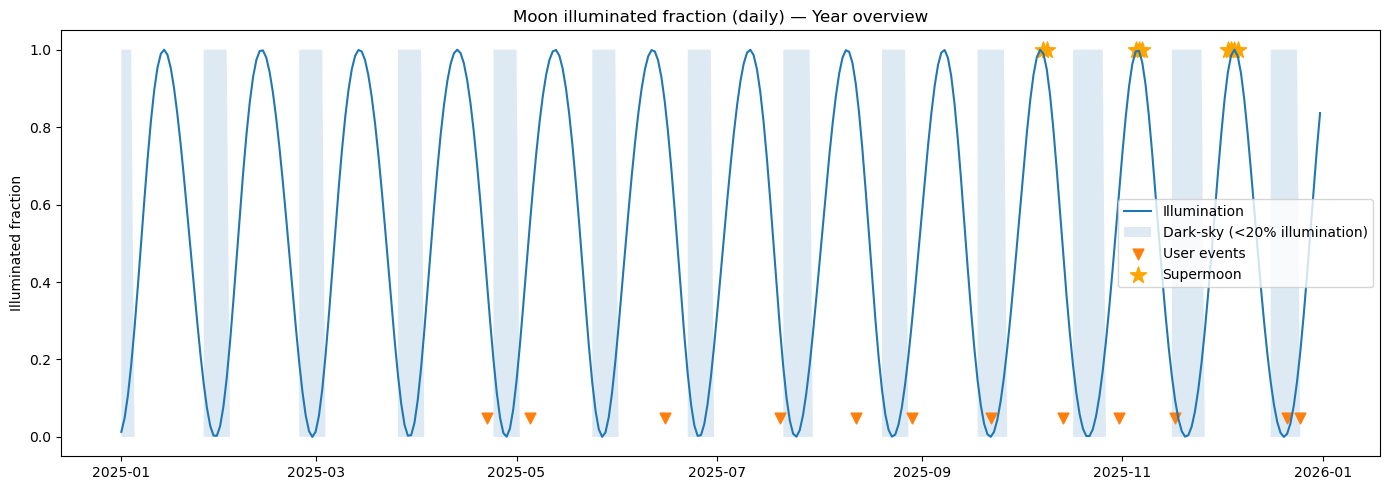

In [6]:
# Simple plot: illuminated fraction through the year, with event markers and dark-sky shading
fig, ax = plt.subplots(figsize=(14,5))
dates = pd.to_datetime(lunar_df.reset_index()['date'])
ax.plot(dates, lunar_df['illum_frac'], linewidth=1.5, label='Illumination')

# Shade dark-sky days
dark_mask = lunar_df['illum_frac'] < 0.20
ax.fill_between(
    dates,
    0,
    1,
    where=dark_mask,
    alpha=0.15,
    label='Dark-sky (<20% illumination)',
    interpolate=True,
)

# Mark user events
ev_dates = pd.to_datetime(events['date'])
ax.scatter(ev_dates, [0.05]*len(ev_dates), marker='v', s=60, label='User events')

# mark supermoons
if supermoon_dates:
    ax.scatter(pd.to_datetime(supermoon_dates), [1.0]*len(supermoon_dates), marker='*', s=150, color='orange', label='Supermoon')

ax.set_ylabel('Illuminated fraction')
ax.set_title('Moon illuminated fraction (daily) — Year overview')
ax.set_ylim(-0.05, 1.05)
ax.legend()
plt.tight_layout()
plt.show()

In [7]:
def monthly_report(df, year, month):
    """Return a small report (dict) summarizing dark-sky nights and events for a month."""
    idx = (pd.to_datetime(df.reset_index()['date']).dt.year == year) & (pd.to_datetime(df.reset_index()['date']).dt.month == month)
    month_df = df.reset_index()[idx].set_index('date')
    dark_nights = month_df[month_df['dark_sky']]
    
    # Get events for the month
    events = df.reset_index()
    if 'has_event' in events.columns:
        month_events = events[(pd.to_datetime(events['date']).dt.year==year) & (pd.to_datetime(events['date']).dt.month==month) & events['has_event']]
    else:
        # If has_event column doesn't exist, check for non-null title
        month_events = events[(pd.to_datetime(events['date']).dt.year==year) & (pd.to_datetime(events['date']).dt.month==month) & events['title'].notna()]
    
    report = {
        'year': year,
        'month': month,
        'num_days': len(month_df),
        'dark_nights': dark_nights.index.tolist(),
        'events': month_events[['title','date','category','notes']].to_dict(orient='records') if not month_events.empty else []
    }
    return report

# Example monthly report for April 2025
report_april = monthly_report(merged, 2025, 4)
report_april


{'year': 2025,
 'month': 4,
 'num_days': 30,
 'dark_nights': [datetime.date(2025, 4, 1),
  datetime.date(2025, 4, 2),
  datetime.date(2025, 4, 24),
  datetime.date(2025, 4, 25),
  datetime.date(2025, 4, 26),
  datetime.date(2025, 4, 27),
  datetime.date(2025, 4, 28),
  datetime.date(2025, 4, 29),
  datetime.date(2025, 4, 30)],
 'events': [{'title': 'Planned Observation',
   'date': datetime.date(2025, 4, 22),
   'category': 'observation',
   'notes': 'Deep-sky imaging - target: M42'}]}